# Receiver Functions - Probing Crust and Mantle with Earthquake Records
Receiver Functions are one way to get an idea of some of the properties in the Solid Earth. Essentially, they exploit the fact that an elastic wave crossing an impedance contrast (i.e., a boundary at which the seismic velocity and/or the material's mass density changes) is refracted. For example, a pressure/P-wave produces not only a refracted P but also S-wave(s).

In practice, we can use receiver functions to infer depth and position of **discrete boundaries** of **elastic** material properties. They work well for sudden strong changes in velocity and density. They are not very informative for smooth transitions, for which seismologists tend to use so-called tomographies. Changes in material properties that do not have any influence on mass density or the wave's velocity/phase speed will not be visible.

## Before the Practical: Installation and preparation
To make this practical go as smooth as possible, please install some programs and download the sample data before coming to the lecture.

Here is the list of resources:

1. Download the installation files from GitHub: 
1. Install miniforge or anaconda: you can find the instructions on how to install minforge for your operating system here: [https://conda-forge.org/download/](https://conda-forge.org/download/). We use this environment to easily install and remove python packages and manage installations.
2. Open a terminal (on Windows: search for ``cmd`` and execute; on Linux/Mac: open ``terminal``). Navigate to you downloads folder with ``cd /path/to/the/what/you/downloaded/above`` Now type: ``conda create -f environment.yml`` and press enter. This will take a small moment.
3. Now, we type ``conda activate rf-practical`` to switch to the new environment.
4. Start Jupyter: Type ``jupyter notebook`. You can open the exercise notebook.

## 00 - Setup the data download, select the Earthquakes

Because only large earthquakes and certain distances have been shown to be useful for receiver functions, we will have to find the right events for our seismic station. We will have a look at several seismic stations and compare the results to each other. We will also play around with some more technical aspects of the receiver function computation.

In [64]:
from obspy import UTCDateTime

from pyglimer.waveform.request import Request

# Define file locations
proj_dir = 'database'

request_dict = {
    # Necessary arguments
    'proj_dir': proj_dir,
    'raw_subdir': 'waveforms/raw_mseed', # Directory of the waveforms
    'prepro_subdir': 'waveforms/preprocessed_RTZ',  # Directory of the preprocessed waveforms
    'rf_subdir': 'waveforms/RF_it',  # Directory of the receiver functions
    'statloc_subdir': 'stations', # Directory stations
    'evt_subdir': 'events',     # Directory of the events
    'log_subdir': 'log',        # Directory for the logs
    'loglvl': 'WARNING',        # logging level
    'format': 'sac',          # Format to save database in
    "phase": "P",               # 'P' or 'S' receiver functions
    "rot": "RTZ",               # Coordinate system to rotate to
    "deconmeth": "it",  # Deconvolution method
    "starttime": UTCDateTime(2018, 1, 1, 0, 0, 0), # Starttime of database.
                                 # In this case, starttime of HRV
    "endtime": UTCDateTime(2022, 1, 1, 0, 0, 0), # Endtimetime of database
    # kwargs below
    "pol": 'v',                  # Source wavelet polaristion. Def. "v" --> SV
    "minmag": 5.5,               # Earthquake minimum magnitude. Def. 5.5
    "event_coords": None,        # Specific event?. Def. None
    "network": "G",             # Restricts networks. Def. None
    "station": "RER",            # Restricts stations. Def. None
    "waveform_client": ['IRIS'], # FDSN server client (s. obspy). Def. None
    "evtcat": 'UP_exc'               # If you have already downloaded a set of
                                 # events previously, you can use them here
}

# Initialiase the request
R = Request(**request_dict)

## Exc. 01: Our Earthquake Catalogue

We have now successfully downloaded/opened an earthquake catalogue containing all large (above magnitude 5.5) earthquakes between 2018 and 2021. We can open the catalogue and plot their locations.

***Q: Look at the locations and try to describe them. Do you notice any patterns? Thinking back to what you already know, can you attempt to give an explanation of what physical mechanism(s) may cause these earthquakes to be in the locations that you plotted?***

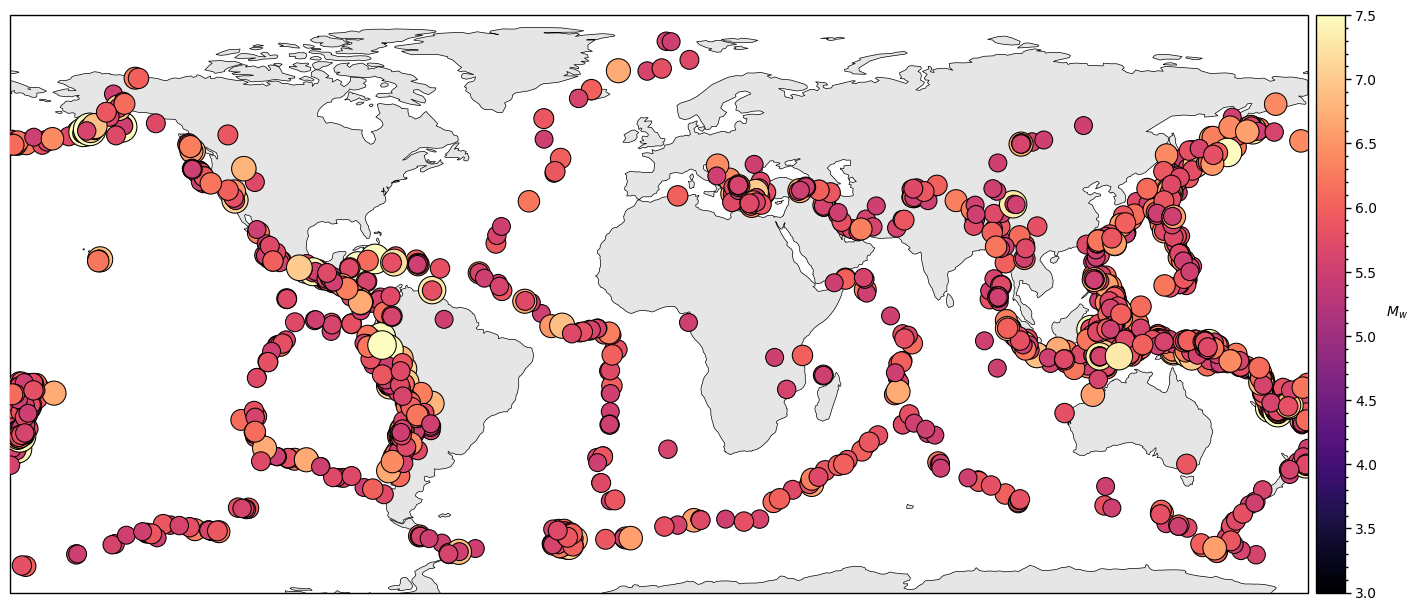

In [65]:
from pyglimer.plot.plot_utils import set_mpl_params
from pyglimer.plot.plot_utils import plot_catalog
set_mpl_params()
plot_catalog(R.evtcat)

## Do not execute: Download the waveforms
As yo have download the exercise data before, you will not need to execute this step.

Let me explain what would happen though: First, the program checks for each event whether it has the right distance to the station. Then, it calculates when the *direct P-wave* of each earthquake arrived at our station (in our case, in Massachusetts, US and La Réunion, French overseas territory in the Indian Ocean) and downloads the its recording around that time.

In [ ]:
R.download_waveforms_small_db(channel='BH?')

--> Enter TOA event loop for station G.RER


## Explore: What do earthquakes look like on a seismogram?
Let's plot one of our waveforms and check what they actually look like on a seismogram. Here we will look at the M7.2 Oxaca earthquake (Mexico).

  plt.setp(ax.get_xticklabels(), fontsize='small')

  plt.setp(ax.get_xticklabels(), fontsize='small',



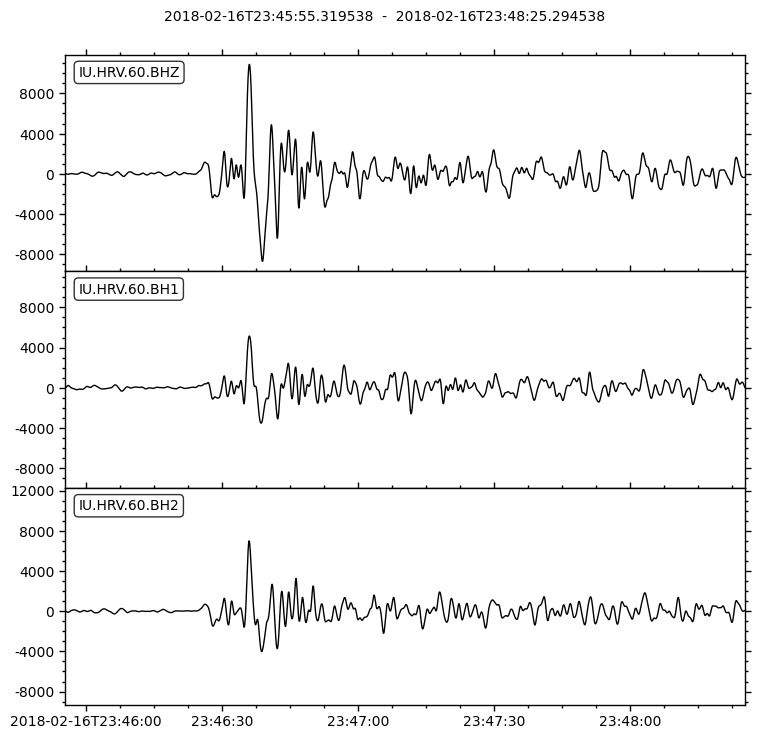

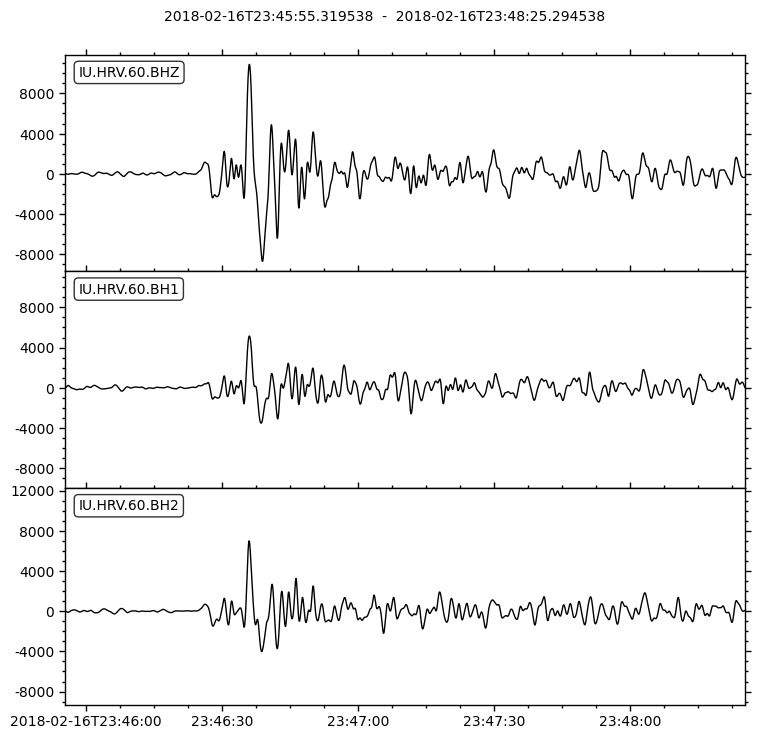

In [ ]:
from obspy import read
st = read('./database/waveforms/raw_mseed/P/2018047T233940_16.5_-98.0/IU.HRV.mseed').filter('bandpass', freqmin=0.1, freqmax=1)[:3]
st.plot()

## Compute the receiver functions.

Now, that we have all the waveform data in place.
We can perform the first preprocessing. This part includes:

1. Clips waveform to the right length before and ta after theorethical arrival.
2. Do some other preprocessing steps. (detrending, filtering, tapering...)
3. **As we have three component waveforms, we can rotate them into a different coordinate system using simple linear algebra (rotational matrices). We do this to isolate the different wavetypes as well as possible. We can play around with the different options later.**
4. Automatically check the waveforms and reject the ones that are too noisy.
5. Write preprocessed waveforms to folder
   specified above ``prepro_subdir``.
6. **Deconvolution with method ``deconmeth`` from our dict is perfomed. We do this to effectively remove the fingerprint of the earthquake/source and only retain information of the underground under our station. We will also come back to this later.**

In [ ]:
R.preprocess(hc_filt=1.5, client='single')

100%|██████████| 3/3 [00:00<00:00, 34.30it/s]


## Open our first RF

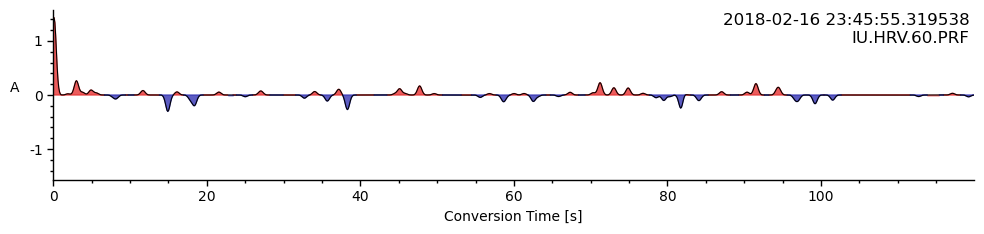

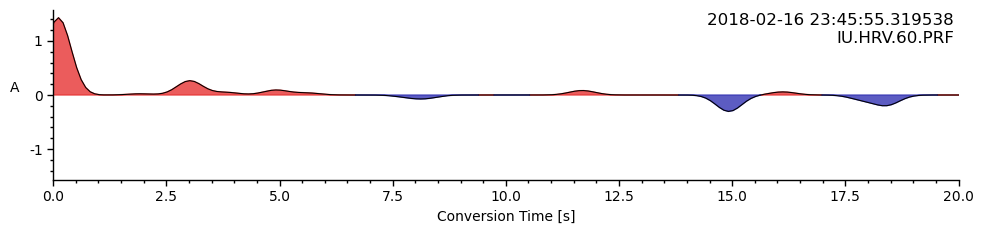

<Axes: xlabel='Conversion Time [s]', ylabel='A    '>

In [ ]:
from pyglimer.rf.create import read_rf

rfst = read_rf("database/waveforms/RF_it/P/IU/HRV/IU.HRV.2018047T233940.sac")
rfst.plot()
rfst[0].plot(lim=[0,20])

### EXC02: Looking at the receiver function
Above you just plotted your very first receiver function - in the so-called time domain. Here, the time axis (x) is seconds after the first P-wave arrival. So basically the time it takes for a converted wave to arrive after our first arrival.

***Q: Look at the plots. What can you tell from them? Can you actually extract any useful information? If not, try to explain why.***

## Plotting receiver functions as a function of distance

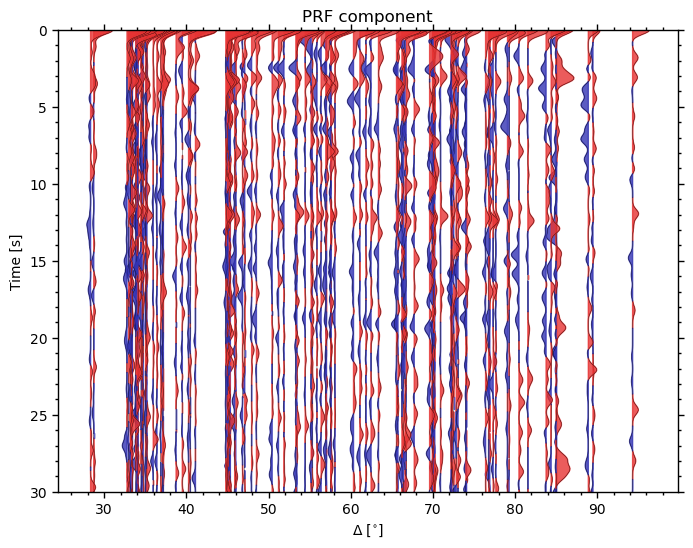

<Axes: title={'center': 'PRF component'}, xlabel='$\\Delta$ [$^{\\circ}$]', ylabel='Time [s]'>

In [ ]:
from pyglimer.rf.create import read_rf
rfst = read_rf("database/waveforms/RF_it/P/IU/HRV/*.sac")
rfst_RER = read_rf("database/waveforms/RF_it/P/G/RER/*.sac")


rfst.plot(scalingfactor=2, lim=(0, 30))

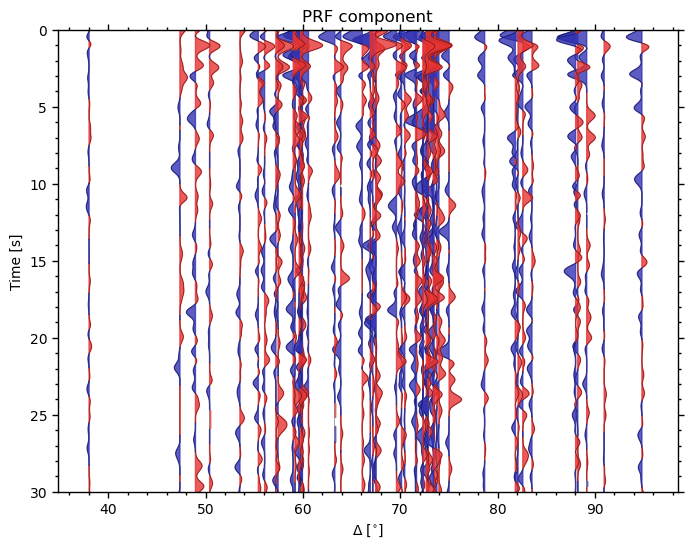

<Axes: title={'center': 'PRF component'}, xlabel='$\\Delta$ [$^{\\circ}$]', ylabel='Time [s]'>

In [ ]:
rfst_RER.plot(scalingfactor=2, lim=(0, 30))

### EXC03: Identifying some (ir)regularities

We have just plotted a bunch of receiver functions from the same station but all from different events. The functions are sorted by epicentral-distance (i.e., distance station-earthquake).

***Q1: Can you see consistent patterns in the receiver functions? Maybe you could identify some first boundaries already?***


***Q2: Do you see changes with epicentral distance, maybe you could attempt to explain why the functions could be different?***

## Transfer (migrate) the receiver functions into depth domain
Obviously, it is not always very useful to have only conversion time. If we have an idea of the velocities that P- and S-waves travel at ($v_P$ and $v_S#, respectively), we can use some middle school maths to calculate the time difference at which they arrive at the surface at. Or to express it mathematically:
$$
z = (t_S-t_P)*(v_S-v_P)
$$

where $z$ is the conversion depth, $t_P$ and $t_S$ are the times that P and S-waves need from the conversion point.

Note that our receiver functions, is currently a function of $\tau=t_S-t_P$...convenient! So the only thing we actually need are some information about the wave velocities. Luckily, others have done the work for us and there are various tables that we can look into. For this first time, we will use the IASP91 model, which is a simple 1D reference model. It (quite wrongly) assumes that the P and S-wave velocities are a pure function of depth and do not differ any where on Earth.

In [ ]:
velocity_model = "iasp91.dat"  # can be iasp91.dat or 3D
z, rfstm = rfst.moveout(velocity_model)

  q_a = np.sqrt(vp**-2 - p**2)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarning, stacklevel=1)

  warnings.warn(mes, category=UserWarnin

### Stack/average all receiver functions

As you have probably noticed before, receiver functions are a quite noisy business and it is often kind of hard to tell whether some boundaries are real or just artefacts in our data.

One easy way to deal with this is just to stack our receiver functions.

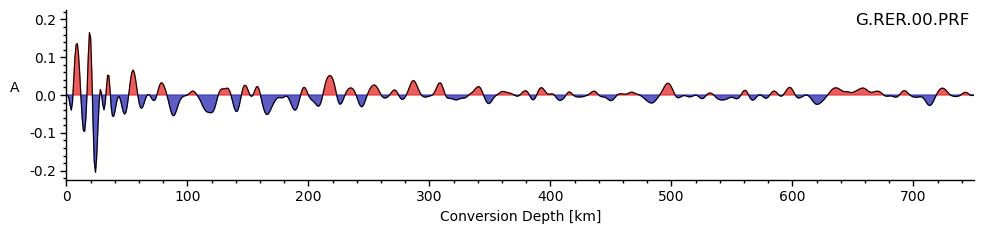

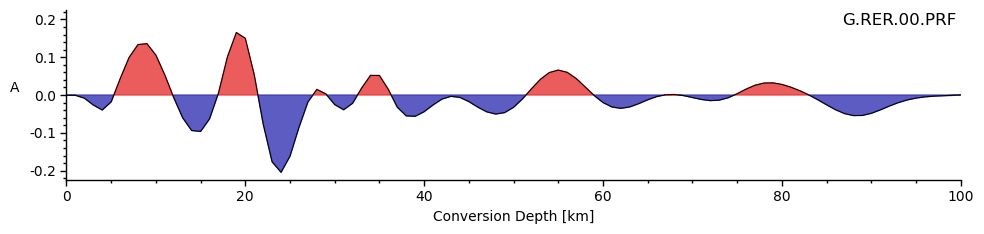

<Axes: xlabel='Conversion Depth [km]', ylabel='A    '>

In [ ]:
stack = rfstm.station_stack()[1]
stack.plot()

stack.plot(lim=[0,100])

### EXC04: Make some wild speculations about the subsurface

Now we can actually make some claims about the subsurface. If you have a creative mind and if it were the early 2000s, you could write a Nature paper now, congrats!

Ok, let's be serious: Obviously, this gives us a very gappy idea of what might happen in the subsurface. But we can maybe say something.

***Q1: Looking at the first few km of the crust. The Mohorovicic (or for the sake of all seismologists' tongue simply "Moho") discontinuity is usually the strongest seismic reflector, this is the boundary separating crust and mantle. At what depth is this boundary under station IU.HRV?***

***Q2: Why is the order of depth migration and stacking/averaging important? Could we not just have stacked our time dependent receiver functions?***

***Q3: Two cells above, change the velocity model to "3D". This will cause the code to look up the velocities in a table that has different velocities for different locations of the Earth. Compare: How different is the result? (Hint: You might want to create a different variable for the new depth migrated receiver functions, so you can plot both the new and the old migrated functions against each other)***



## EXC05: Repeat and compare with La Réunion Island.

When obtaining the data, you have also downloaded data from station *G.RER*, which is located on beautiful La Réunion in the Pacific Ocean - close to Madagascar. Geologically (probably also in other aspects), La Réunion is quite different from the Eastern US. La Réunion is a volcanic island and sits on a hotspot - a place where the crust is often particularly thin.

Here comes the part, in which you will have to code a little yourself. But no worries it is very easy, you will just have to change some variables in the cells above.

**Hint: For the La Réunion station "G" is the network code and "RER" the station code. For the Havard station, it was "IU" and "HRV".**

***Q1: Execute the computations above for the new station by changing the variables for network and station. Read in the data from both IU.HRV and G.RER by using the read_rf command. Then, compare the depth migrated functions. How do they differ? Where do you think the Moho under La Réunion could be?***

**Optional exercises:**

***QO1: Play around with the deconvolution method. You could for instance use water-level deconvolution (which is executed in frequency domain, whereas we used a little more complex time domain algorithm). Do this by changing the parameter ``deconmeth`` to ``wl``. Make sure to change the output folders for the receiver functions to not overwrite your old data! How different do the individual receiver functions look? Do you also see a difference in the stack?***

***Q02: Try a different rotational algorithm. So far, we have used the RTZ coordinate system, keeping the horizontal coordinate axes parallel to the surface. we could change to the P-SV-SH coordinate system that aligns our coordinate axes with the actual particle motions. You can do this by changing parameter ``rot``to ``PSS``. Make sure to change the output folders for the receiver functions to not overwrite your old data! Can you notice improvements in our receiver functions?***